In [1]:
import pandas as pd
import numpy as np
import scipy
import csv
import re
import nltk
from nltk.tokenize import TweetTokenizer 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import itertools
from random import *

import matplotlib.pyplot as plt


pd.set_option('display.max_colwidth', -1) # to show all the content of the colum text

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#TODO: 

# check which words are cutted out after join with embeddings db 
# check word distance to see why current embedding is not good
# write down experiments glove, sent x avg, sum
# explore other models: lstm newtwork



# add stop words
# use sentiment oriented embedding (skype Eric)
# check degree of coverage of my spanigh tweet by using the pre-trained vectors
# approach for uncovered words (all 0?, delete these words from the tweet -> cleansing? depends on the coverage! e da quali tolgo!)
# build a dictionary tweet (nearly ready)
# build features from dictionary (done)
# add stop words
# re-try current models




# IMPORTS 

In [3]:
# IMPORT TWEET FILE

df = pd.read_csv("C:/Users/cvalentino/Desktop/UB - Data Science/Project/data/tweets_publics_2.csv", encoding='utf-16', 
                 index_col='tweet_id', 
                 sep=',')

df.airline_sentiment = pd.Categorical(df.airline_sentiment)

df.head(1)

,airline_sentiment,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,
942743012337123328,positive,False,0,0,"""Los pilotos de Ryanair desconvocan la huelga tras ver reconocidos sus sindicatos"" by El País via Últimas noticias… https://t.co/80Fz6dxP9t",NaN,Mon Dec 18 13:07:04 +0000 2017,NaN,Dublin


In [5]:
# IMPORT SPANISH STOPWORDS

spanish_stp_wrd = pd.read_csv("C:/Users/cvalentino/Desktop/UB - Data Science/Project/spanish_stop_words.csv", encoding='ansi')

spanish_stp_wrd = spanish_stp_wrd.word.tolist()

In [7]:
#IMPORT PRE-TRAINED WORD VECTORS (GLOVE or ULTRADENSE, to be decided)

#words = pd.read_csv("C:/Users/cvalentino/Desktop/UB/Project/es_corpus-form-skip_400_10_50_transformed.txt", sep=" ", index_col=0, encoding = "UTF-8", header=None, quoting=csv.QUOTE_NONE)

words = pd.read_table("C:/Users/cvalentino/Desktop/UB - Data Science/Project/glove twitter/glove.twitter.27B.200d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

words.head(2)


,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
0,,,,,,,,,,,,,,,,,,,,,
<user>,0.31553,0.537650,0.10177,0.032553,0.003798,0.015364,-0.203440,0.33294,-0.20886,0.10061,...,-0.062927,0.26674,-0.23617,0.181090,-0.265830,0.090904,-0.81205,-0.456640,-0.465400,0.52066
.,0.35132,0.000561,-0.21488,-0.047070,-0.177770,0.661620,-0.007481,-0.15963,-0.22129,0.65523,...,-0.443700,0.14186,-0.42475,0.023551,-0.096965,0.079513,-1.46830,0.036684,-0.037206,0.85384


# FUNCTIONS

In [8]:
# DEFINITION OF CLEANING FUNCTION 

def clean_tweets(tweet):
    
    #Convert all to lower case
    tweet = tweet.lower()
       
    #Convert www.* or https://.* to ''
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    
    #Convert @username to ''
    tweet = re.sub('@[^\s]+','',tweet) 
    
    #Convert #word to word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    #remove everything that is not letter (eliminates numbers, commas, brackets, ...) - manages properly spanish accents
    tweet = re.sub("[^a-záéíóúñüA-Z]", " ",tweet) 
        
      
    # Repeating words like happyyyyyyyy
    rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE)
    tweet = rpt_regex.sub(r"\1\1", tweet)
     
    
    
    #Stop words (spanish)
    #managed by count vectorizer
    
    
    
    return tweet



In [9]:
#trim function (Removes extra whitespaces in the text)

def space_trim(tweet):
    #tweet = tweet.strip('\'"')
    " ".join(tweet.split())
    #tweet = re.sub(' +','  ',tweet)
    return " ".join(tweet.split())
    #return tweet

In [10]:
# function to access the words representation

def vec(w):
    return words.loc[w].as_matrix()


In [11]:
# function to check similarity between words (cosine distance)

def similarity(w1, w2):
    
    cosine_dist = spatial.distance.cosine(vec(w1), vec(w2))
    
    return 1 - cosine_dist

In [12]:
# function to transform each tweet into and embedded vector (SUM)

tw = TweetTokenizer()

def word_emb_sum(tweet):
    tweet = sum(vec(tw.tokenize(tweet)))
    return tweet
        

In [13]:
# function to transform each tweet into and embedded vector (AVG)

tw = TweetTokenizer()

def word_emb_avg(tweet):
    tweet = sum(vec(tw.tokenize(tweet)))/len(tweet.split())
    return tweet


In [14]:
# tweet lenght function

def tweet_len(tweet):  
    
    tokens = tweet.strip().split()
    
    return len(tokens)

In [15]:
# function to remove spanish stop words

def replace_stop_words(tweet):
    
    tokens = tweet.strip().split()
    
    for i,t in enumerate(tokens):
        if t in spanish_stp_wrd:
            tokens[i] = ''
    
    return ' '.join(tokens)

In [16]:
# function to remove un-embedded words

def replace_non_cov_sub(tweet):
    
    tokens = tweet.strip().split()
    
    for i,t in enumerate(tokens):
        if t in non_cov_sub:
            tokens[i] = ''
    
    return ' '.join(tokens)

In [17]:
# function to remove un-embedded words

def replace_non_cov(tweet):
    
    tokens = tweet.strip().split()
    
    for i,t in enumerate(tokens):
        if t in non_cov:
            tokens[i] = ''
    
    return ' '.join(tokens)

In [18]:
# function to plot confusion matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
# fast function to find closest words (da provare)

words_matrix = words.as_matrix()

def find_closest_word(v):
    diff = words_matrix - v
    delta = np.sum(diff * diff, axis=1)
    i = np.argmin(delta)
    return words.iloc[i].name

In [20]:
def rand_ass(rnd_num):
    
    if rnd_num <= neu:
    
        pred = 'neutral'
    
    else:
        pred = 'positive'
        
    return pred

# DATA CLEANSING + FEATURE ENG.



In [21]:
#CREATION OF THE CLEANSED DB

df_clean = df[['airline_sentiment', 'text']].copy()
df_clean['text_clean'] = df_clean.text.apply(clean_tweets)
df_clean['text_clean'] = df_clean.text_clean.apply(space_trim)

df_clean.head(2)

,airline_sentiment,text,text_clean
tweet_id,,,
942743012337123328,positive,"""Los pilotos de Ryanair desconvocan la huelga tras ver reconocidos sus sindicatos"" by El País via Últimas noticias… https://t.co/80Fz6dxP9t",los pilotos de ryanair desconvocan la huelga tras ver reconocidos sus sindicatos by el país via últimas noticias
926857871916183553,positive,"@Iberia @lavecinarubia Si ,por favor las declaraciones de amor entre los #rubijarena no pueden quedarse en una ma… https://t.co/GWKJGhhubY",si por favor las declaraciones de amor entre los rubijarena no pueden quedarse en una ma


In [22]:
# DEGREE OF COVERAGE OF CURRENT TWEETS


#make the tweet a set
tweet_set = set(itertools.chain.from_iterable(df_clean['text_clean'].str.split().tolist()))

#make the emb vectors a set
emb_set = set(words.index.tolist())

#showing which tweet words are NOT covered by embeddings
non_cov = [w for w in list(tweet_set) if w not in emb_set]

#calculating coverage of tweets
coverage = len([w for w in list(tweet_set) if w in emb_set]) / len(tweet_set)

print(coverage)
#print(non_cov)



0.8833546189868029


In [23]:
# apply the function to remove un-embedded words

df_clean['text_clean'] = df_clean.text_clean.apply(replace_non_cov)

In [24]:
# apply the function to remove spanish stop words

df_clean['text_clean'] = df_clean.text_clean.apply(replace_stop_words)


In [25]:
#REMOVE RECORD WHEN TEXT_CLEAN EMPTY (needed after previous step + to manage the following)

df_clean['text_clean'] = df_clean.text_clean.apply(space_trim)


In [26]:
# ADD NORMALIZED LENGHT AS FEATURE


df_clean['text_clean_len'] = df_clean.text_clean.apply(tweet_len)

avg_len = df_clean['text_clean_len'].mean()

df_clean['text_clean_len'] = df_clean.text_clean_len.apply(lambda x : x/avg_len)

df_clean.head(2)


,airline_sentiment,text,text_clean,text_clean_len
tweet_id,,,,
942743012337123328,positive,"""Los pilotos de Ryanair desconvocan la huelga tras ver reconocidos sus sindicatos"" by El País via Últimas noticias… https://t.co/80Fz6dxP9t",pilotos de ryanair huelga ver reconocidos sindicatos by país via últimas noticias,1.157295
926857871916183553,positive,"@Iberia @lavecinarubia Si ,por favor las declaraciones de amor entre los #rubijarena no pueden quedarse en una ma… https://t.co/GWKJGhhubY",favor declaraciones de amor no quedarse ma,0.675089


In [28]:
#### Split df_clean DB in len > o and len <> 0

df_clean_0 = pd.DataFrame(df_clean[df_clean.text_clean_len == 0], index = df_clean.index)
df_clean_0 = df_clean_0.dropna(how = 'all')

df_clean_1 = pd.DataFrame(df_clean[df_clean.text_clean_len > 0], index = df_clean.index)
df_clean_1 = df_clean_1.dropna(how = 'all')


In [29]:
# APPLY THE EMBEDDING FUNCTION TO THE DB (for len > 0)


df_clean_1['emb'] = df_clean_1.text_clean.apply(word_emb_avg)

df_clean_1.head(1)





,airline_sentiment,text,text_clean,text_clean_len,emb
tweet_id,,,,,
942743012337123328,positive,"""Los pilotos de Ryanair desconvocan la huelga tras ver reconocidos sus sindicatos"" by El País via Últimas noticias… https://t.co/80Fz6dxP9t",pilotos de ryanair huelga ver reconocidos sindicatos by país via últimas noticias,1.157295,"[-0.0756691666667, 0.113217833333, -0.09312275, -0.244272833333, 0.0502903333333, 0.131632666667, -0.5281, -0.213104833333, 0.02320725, 0.2133695, 0.220582666667, -0.0851987583333, 0.00227433333333, 0.315125416667, 0.0674625, -0.184501916667, -0.133407166667, 0.0699309166667, 0.296428833333, 0.07840225, -0.100271083333, -0.38960375, 0.01355975, -0.22332925, 0.240805333333, -1.97416583333, -0.111133666667, -0.0869692916667, -0.0985511666667, -0.146179916667, 0.0545521666667, -0.0969879166667, 0.18415025, -0.0741793916667, 0.111800083333, 0.142629916667, -0.11314925, -0.0589209833333, -0.571868333333, 0.233612666667, -0.186156833333, 0.0375613916667, 0.0143769833333, -0.190641508333, 0.0888565583333, 0.0112394333333, -0.00618166666667, -0.0863886666667, -0.029735, -0.0883031666667, 0.0824091666667, -0.0468364675, -0.026942525, 0.360257866667, 0.123257166667, 0.132978, 0.116480833333, -0.0384376666667, 0.140027191667, -0.0468111666667, 0.0381866666667, -0.0259200916667, 0.0811904166667, 0.147979833333, 0.334073116667, 0.12065875, 0.290338416667, 0.236763325, 0.0219423333333, 0.0868206666667, -0.257362, -0.40549425, 0.166849083333, -0.155061666667, -0.0766273333333, -0.283677666667, -0.00297780833333, 0.0408959166667, -0.0800915833333, 0.08869175, -0.173477666667, -0.0799354166667, 0.0141543333333, 0.164830333333, 0.0518576666667, -0.130946666667, 0.0780064166667, -0.0831865833333, 0.137945316667, -0.136815833333, -0.07809475, -0.0852737509167, -0.0995658333333, 0.0806385833333, -0.105238833333, 0.22687375, 0.0302075833333, 0.2206285, -0.0761453333333, -0.0548439166667, ...]"


# MODEL

In [31]:
# MODELS DEFINITION

BERN = BernoulliNB()
LOG = LogisticRegression()
SVM = svm.SVC()
RANDF = RandomForestClassifier()
MLP = MLPClassifier(hidden_layer_sizes=(200,10000, 10), max_iter= 200)



In [32]:
# data prep for cross validation

# DATA PREP
#removing records with word embedding = 0 (empty cleansed tweet), storing the len and prob

tot = len(df_clean[df_clean.text_clean_len == 0])
neg_n = len((df_clean[(df_clean.text_clean_len == 0) & (df_clean.airline_sentiment == 'negative')]))
neu_n = len((df_clean[(df_clean.text_clean_len == 0) & (df_clean.airline_sentiment == 'neutral')]))
pos_n = len((df_clean[(df_clean.text_clean_len == 0) & (df_clean.airline_sentiment == 'positive')]))

# rescalded without negative
neg = neg_n/tot
neu = neu_n/(neu_n + pos_n)
pos = pos_n/(neu_n + pos_n)


# delete empty tweets from training set: prediction will be based on class probability
df_clean = df_clean[~df_clean.text_clean_len.apply(lambda a: False if a != 0 else True)]


ZeroDivisionError: division by zero

In [33]:
#DATA PREP
# APPLY THE EMBEDDING FUNCTION TO THE DB (for len > 0)


df_clean['emb'] = df_clean.text_clean.apply(word_emb_avg)

df_clean.head(1)


,airline_sentiment,text,text_clean,text_clean_len,emb
tweet_id,,,,,
942743012337123328,positive,"""Los pilotos de Ryanair desconvocan la huelga tras ver reconocidos sus sindicatos"" by El País via Últimas noticias… https://t.co/80Fz6dxP9t",pilotos de ryanair huelga ver reconocidos sindicatos by país via últimas noticias,1.157295,"[-0.0756691666667, 0.113217833333, -0.09312275, -0.244272833333, 0.0502903333333, 0.131632666667, -0.5281, -0.213104833333, 0.02320725, 0.2133695, 0.220582666667, -0.0851987583333, 0.00227433333333, 0.315125416667, 0.0674625, -0.184501916667, -0.133407166667, 0.0699309166667, 0.296428833333, 0.07840225, -0.100271083333, -0.38960375, 0.01355975, -0.22332925, 0.240805333333, -1.97416583333, -0.111133666667, -0.0869692916667, -0.0985511666667, -0.146179916667, 0.0545521666667, -0.0969879166667, 0.18415025, -0.0741793916667, 0.111800083333, 0.142629916667, -0.11314925, -0.0589209833333, -0.571868333333, 0.233612666667, -0.186156833333, 0.0375613916667, 0.0143769833333, -0.190641508333, 0.0888565583333, 0.0112394333333, -0.00618166666667, -0.0863886666667, -0.029735, -0.0883031666667, 0.0824091666667, -0.0468364675, -0.026942525, 0.360257866667, 0.123257166667, 0.132978, 0.116480833333, -0.0384376666667, 0.140027191667, -0.0468111666667, 0.0381866666667, -0.0259200916667, 0.0811904166667, 0.147979833333, 0.334073116667, 0.12065875, 0.290338416667, 0.236763325, 0.0219423333333, 0.0868206666667, -0.257362, -0.40549425, 0.166849083333, -0.155061666667, -0.0766273333333, -0.283677666667, -0.00297780833333, 0.0408959166667, -0.0800915833333, 0.08869175, -0.173477666667, -0.0799354166667, 0.0141543333333, 0.164830333333, 0.0518576666667, -0.130946666667, 0.0780064166667, -0.0831865833333, 0.137945316667, -0.136815833333, -0.07809475, -0.0852737509167, -0.0995658333333, 0.0806385833333, -0.105238833333, 0.22687375, 0.0302075833333, 0.2206285, -0.0761453333333, -0.0548439166667, ...]"


In [54]:
# CROSS VALIDATION

model = SVM

#BERN = BernoulliNB()
#LOG = LogisticRegression()
#SVM = svm.SVC()
#RANDF = RandomForestClassifier()
#MLP = MLPClassifier(hidden_layer_sizes=(200,1), max_iter= 200)



X1 = pd.DataFrame(np.array(df_clean.emb.tolist()), index = df_clean.index )
X2 = pd.DataFrame(df_clean.text_clean_len, index = df_clean.index)
X = pd.merge(X1, X2, left_index = True, right_index = True)

scaler = StandardScaler() 
scaler.fit(X)  
X = scaler.transform(X)  

X = scipy.sparse.csr_matrix(X)



y = df_clean.airline_sentiment




scores = cross_val_score(model, X, y, cv=3)


print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.57 (+/- 0.01)


In [ ]:
# CROSS VALIDATION + HYPER parameters tuning by using grid search (WIP)

#BERN = BernoulliNB()
#LOG = LogisticRegression()
#SVM = svm.SVC()
#RANDF = RandomForestClassifier()
#MLP = MLPClassifier(hidden_layer_sizes=(200,1), max_iter= 200)



X1 = pd.DataFrame(np.array(df_clean.emb.tolist()), index = df_clean.index )
X2 = pd.DataFrame(df_clean.text_clean_len, index = df_clean.index)
X = pd.merge(X1, X2, left_index = True, right_index = True)

scaler = StandardScaler() 
scaler.fit(X)  
X = scaler.transform(X)  

X = scipy.sparse.csr_matrix(X)



y = df_clean.airline_sentiment


parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 20],
              'decision_function_shape' : ('ovr', 'ovo')}
        #'gamma': [0.001, 0.0001]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X, y)
print(clf.cv_results_)

In [34]:
#UNIQUE RUN building features X and label Y (with lenght)

X1 = pd.DataFrame(np.array(df_clean_1.emb.tolist()), index = df_clean_1.index )
X2 = pd.DataFrame(df_clean_1.text_clean_len, index = df_clean_1.index)
X = pd.merge(X1, X2, left_index = True, right_index = True)


y = df_clean_1.airline_sentiment


In [35]:
#UNIQUE RUN SPLIT TRAINING-TEST SET

split_coeff = 0.20

#train, test = train_test_split(final_df, test_size = split_coeff)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_coeff, random_state = 42)


In [36]:
#UNIQUE RUN MODEL FIT 


SVM = svm.SVC(C=5, decision_function_shape='ovo', kernel= 'linear')
model = MLP

#BERN = BernoulliNB()
#LOG = LogisticRegression()
#SVM = svm.SVC()
#RANDF = RandomForestClassifier()
#MLP = MLPClassifier(hidden_layer_sizes=(1000,1000,1000), max_iter= 200)


model.fit(X_train,y_train)

#model1.fit(X_train,y_train)
#model2.fit(X_train,y_train)
#model3.fit(X_train,y_train)
#model6.fit(X_train,y_train)

#y_pred1 = model1.predict(X_test) 
#y_pred2 = model2.predict(X_test) 
#y_pred3 = model3.predict(X_test)
#y_pred6 = model6.predict(X_test) 

# MODEL PREDICT

y_pred = model.predict(X_test) 




0.557989690722
             precision    recall  f1-score   support

   negative       0.68      0.68      0.68       733
    neutral       0.44      0.48      0.46       502
   positive       0.47      0.40      0.43       317

avg / total       0.56      0.56      0.56      1552

[[500 179  54]
 [176 240  86]
 [ 64 127 126]]
Confusion matrix, without normalization
[[500 179  54]
 [176 240  86]
 [ 64 127 126]]
Normalized confusion matrix
[[ 0.68  0.24  0.07]
 [ 0.35  0.48  0.17]
 [ 0.2   0.4   0.4 ]]


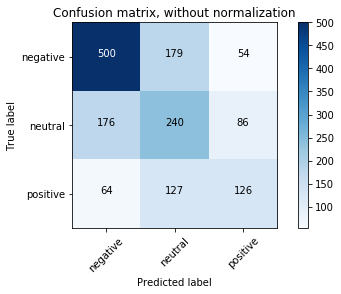

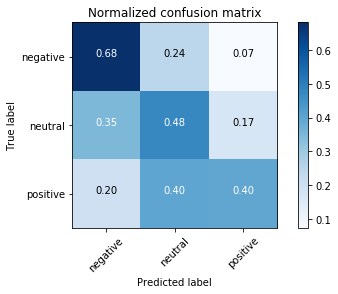

In [37]:

# MODEL RESULTS

print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


#print(metrics.accuracy_score(y_test, y_pred1))
#print(metrics.accuracy_score(y_test, y_pred2))
#print(metrics.accuracy_score(y_test, y_pred3))
#print(metrics.accuracy_score(y_test, y_pred6))

#print(classification_report(y_test, y_pred1))
#print(classification_report(y_test, y_pred2))
#print(classification_report(y_test, y_pred3))
#print(classification_report(y_test, y_pred6))



# Confusion matrix plot

class_names = ['negative', 'neutral', 'positive']


cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


plt.show()

# OTHER

In [95]:
#MULTIPLE RUNS (calculations)

n_models =  4


split_coeff = 0.25
rep = 10

acc_r = np.zeros((rep, n_models))



for i in range(rep):
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_coeff)              
                               
    
    model1.fit(X_train,y_train)
    model2.fit(X_train,y_train)
    model3.fit(X_train,y_train)
    model5.fit(X_train,y_train)

                                 
    y_pred1 = model1.predict(X_test) 
    y_pred2 = model2.predict(X_test) 
    y_pred3 = model3.predict(X_test)
    y_pred5 = model5.predict(X_test)  
    
    acc_r[i][0] = metrics.accuracy_score(y_test, y_pred1)       
    acc_r[i][1] = metrics.accuracy_score(y_test, y_pred2)
    acc_r[i][2] = metrics.accuracy_score(y_test, y_pred3)
    acc_r[i][3] = metrics.accuracy_score(y_test, y_pred5)


  




BernoulliNB               0.573182
LogisticRegression        0.603198
SVM                       0.627024
RandomForestClassifier    0.554513
dtype: float64


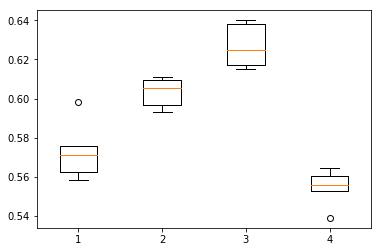

In [48]:
#MULTIPLE RUNS (graph)

results = pd.DataFrame(acc_r, columns = ['BernoulliNB', 'LogisticRegression',	'SVM',	 'RandomForestClassifier'])
print(results.mean())


plt.boxplot(acc_r)
plt.show()
ax = plt.gca()
ax.set_xticklabels(['BernoulliNB', 'LogisticRegression',	'SVM',	 'RandomForestClassifier'])


In [93]:
# MULTIPLE RUNS, distributions of sentiments

print(len(pd.DataFrame(y_pred1)[pd.DataFrame(y_pred1)[0] == 'negative'])/len(y_pred1))
print(len(pd.DataFrame(y_pred1)[pd.DataFrame(y_pred1)[0] == 'neutral'])/len(y_pred1))
print(len(pd.DataFrame(y_pred1)[pd.DataFrame(y_pred1)[0] == 'positive'])/len(y_pred1))

print(len(pd.DataFrame(y_test)[pd.DataFrame(y_test).airline_sentiment == 'negative'])/len(y_test))
print(len(pd.DataFrame(y_test)[pd.DataFrame(y_test).airline_sentiment == 'neutral'])/len(y_test))
print(len(pd.DataFrame(y_test)[pd.DataFrame(y_test).airline_sentiment == 'positive'])/len(y_test))

0.5461578133058278
0.298091799896854
0.1557503867973182
0.4889118102114492
0.3145951521402785
0.1964930376482723


In [226]:
result = pd.merge(pd.DataFrame(y_pred3), df_clean, right_index = True, left_index = True)
result.rename(columns={'0':'predicted_sent'}, inplace=True)

In [227]:
result.head(100)


,0,airline_sentiment,text,text_clean,emb
0,negative,positive,"""Los pilotos de Ryanair desconvocan la huelga tras ver reconocidos sus sindicatos"" by El País via Últimas noticias… https://t.co/80Fz6dxP9t",pilotos de ryanair huelga ver reconocidos sindicatos by país via últimas noticias,"[-0.0752903333333, -0.0359455833333, 0.0650454166667, -0.101761583333, -0.0280869166667, -0.088472, -0.0578008333333, -0.00184541666667, 0.0859379166667, -0.0599359166667, -0.155054833333, 0.0502991666667, 0.112665833333, 0.0406145833333, 0.0974616666667, -0.021894, 0.02024075, 0.102665666667, 0.0310989166667, 0.0460468333333, 0.293605416667, -0.0150535833333, 0.00887016666667, 0.0472463333333, -0.131897, -0.0168893333333, -0.0335726666667, 0.00561341666667, 0.0919178333333, -0.0626511666667, -0.091868, -0.0830126666667, 0.0641129166667, -0.05487025, -0.0917435833333, -0.0571816666667, -0.00978141666667, 0.109478416667, 0.0964466666667, 0.0680418333333, 0.00259766666667, -0.00427658333333, 0.0162516666667, -0.08716175, -0.04003875, -0.0104385, 0.0876275833333, 0.0186139166667, 0.028821, -0.00175516666667, 0.0277215833333, -0.01584425, -0.0595655833333, 0.0387970833333, 0.0241049166667, -0.0246253333333, 0.0680936666667, 0.0479184166667, -0.0583033333333, -0.0774919166667, 0.0442514166667, -0.185884083333, 0.05976075, -0.02815275, 0.00302916666667, -0.021763, 0.01912575, 0.08925175, -0.04767175, 0.0146796666667, -0.0629715, -0.0112064166667, 0.0145258333333, 0.0261776666667, -0.02696525, -0.0995226666667, 0.0566795833333, -0.0380871666667, 0.0999740833333, -0.00678691666667, 0.0738625833333, -0.0937419166667, 0.09477875, -0.0447090833333, -0.070848, -0.0469678333333, -0.0220341666667, 0.140774666667, 0.0164650833333, -0.118251916667, -0.004164, -0.07335375, 0.0477559166667, 0.0771465833333, 0.0589254166667, 0.00627658333333, -0.0062985, -0.0174778333333, -0.00932983333333, 0.0909190833333, ...]"
1,negative,positive,"@Iberia @lavecinarubia Si ,por favor las declaraciones de amor entre los #rubijarena no pueden quedarse en una ma… https://t.co/GWKJGhhubY",favor declaraciones de amor no ma,"[-0.0103038333333, -0.0608481666667, 0.00689233333333, -0.1075645, 0.0529, 0.0361228333333, -0.041848, 0.0400236666667, 0.139941666667, 0.0546595, -0.0833945, 0.007859, 0.118018666667, -0.00887566666667, 0.0667868333333, -0.1528275, -0.035112, 0.114934833333, -0.0794538333333, 0.001224, 0.215415666667, 0.0942553333333, 0.00620433333333, 0.0186836666667, -0.113437333333, -0.1206875, -0.0377518333333, -0.0305773333333, 0.111437166667, -0.0474023333333, -0.06133, 0.112183833333, 0.0521528333333, 0.0445866666667, 0.0631606666667, 0.011139, -0.0044255, 0.0955345, -0.0741973333333, -0.0136888333333, -0.0902425, 0.0776358333333, 0.1405365, -0.1392585, 0.0302891666667, -0.00220066666667, 0.0358908333333, -0.0704353333333, 0.112574, 0.0971941666667, -0.00991466666667, -0.104471833333, 0.0607135, -0.144392166667, 0.0525513333333, 0.0461015, -0.0257965, -0.200526, 0.0796423333333, 0.0614215, 0.091001, -0.0542791666667, 0.00116166666667, 0.0619118333333, -0.0667096666667, 0.126251666667, 0.0366233333333, 0.0686561666667, 0.0525158333333, 0.0279395, 0.0481931666667, -0.0833791666667, 0.0714808333333, -0.0372751666667, -0.00301116666667, -0.0615796666667, 0.019867, 0.114501166667, 0.0413028333333, 0.0158321666667, 0.00759116666667, -0.0208271666667, 0.0299258333333, 0.0520033333333, -0.0112305, 0.103349666667, -0.0563358333333, 0.100633, 0.087888, -0.0144511666667, 0.0284773333333, -0.0127731666667, 0.0636141666667, 0.134555, -0.000125166666667, -0.0826528333333, 0.0752726666667, -0.0135536666667, -0.110947, 0.112296166667, ...]"
2,negative,neutral,@Iberia Me dirías por favor que costo tiene?,me dirías favor que costo,"[-0.136101, -0.128083, -0.0899404, -0.0595304, 0.1612042, -0.0051852, 0.0310528, 0.003107, 0.1668496, -0.1177104, -0.0393476, 0.0127496, 0.156433, -0.0933284, 0.187809, -0.1115106, 0.1018418, 0.1322852, -0.0672622, 0.0323658, 0.1288008, 0.2054072, -0.0365048, 0

# SUBMISSION PROCESSES 

--------------------









In [25]:
# SUBMISSION CONFIG


#1 Model

BERN = BernoulliNB()
LOG = LogisticRegression()
SVM = svm.SVC(decision_function_shape ='ovo', C= 5, kernel = 'linear')
RANDF = RandomForestClassifier()
MLP = MLPClassifier(hidden_layer_sizes=(1000,1000,1000), max_iter= 200)


#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 20],
 #             'decision_function_shape' : ('ovr', 'ovo')}
        #'gamma': [0.001, 0.0001]}


model = SVM

#2 embedding

emb_to_use = word_emb_avg



In [26]:
# DATA PREP
#removing records with word embedding = 0 (empty cleansed tweet), storing the len and prob

tot = len(df_clean[df_clean.text_clean_len == 0])
neg_n = len((df_clean[(df_clean.text_clean_len == 0) & (df_clean.airline_sentiment == 'negative')]))
neu_n = len((df_clean[(df_clean.text_clean_len == 0) & (df_clean.airline_sentiment == 'neutral')]))
pos_n = len((df_clean[(df_clean.text_clean_len == 0) & (df_clean.airline_sentiment == 'positive')]))

# rescalded without negative
neg = neg_n/tot
neu = neu_n/(neu_n + pos_n)
pos = pos_n/(neu_n + pos_n)


# delete empty tweets from training set: prediction will be based on class probability
df_clean = df_clean[~df_clean.text_clean_len.apply(lambda a: False if a != 0 else True)]




In [27]:
print('negative: ',round(neg*100), '%')
print('neutral : ',round(neu*100), '%')
print('positive: ',round(pos*100), '%')


negative:  24 %
neutral :  47 %
positive:  53 %


In [28]:
#DATA PREP
# APPLY THE EMBEDDING FUNCTION TO THE DB (for len > 0)


df_clean['emb'] = df_clean.text_clean.apply(emb_to_use)

df_clean.head(1)


,airline_sentiment,text,text_clean,text_clean_len,emb
tweet_id,,,,,
942743012337123328,positive,"""Los pilotos de Ryanair desconvocan la huelga tras ver reconocidos sus sindicatos"" by El País via Últimas noticias… https://t.co/80Fz6dxP9t",pilotos de ryanair huelga ver reconocidos sindicatos by país via últimas noticias,1.175012,"[-0.0752903333333, -0.0359455833333, 0.0650454166667, -0.101761583333, -0.0280869166667, -0.088472, -0.0578008333333, -0.00184541666667, 0.0859379166667, -0.0599359166667, -0.155054833333, 0.0502991666667, 0.112665833333, 0.0406145833333, 0.0974616666667, -0.021894, 0.02024075, 0.102665666667, 0.0310989166667, 0.0460468333333, 0.293605416667, -0.0150535833333, 0.00887016666667, 0.0472463333333, -0.131897, -0.0168893333333, -0.0335726666667, 0.00561341666667, 0.0919178333333, -0.0626511666667, -0.091868, -0.0830126666667, 0.0641129166667, -0.05487025, -0.0917435833333, -0.0571816666667, -0.00978141666667, 0.109478416667, 0.0964466666667, 0.0680418333333, 0.00259766666667, -0.00427658333333, 0.0162516666667, -0.08716175, -0.04003875, -0.0104385, 0.0876275833333, 0.0186139166667, 0.028821, -0.00175516666667, 0.0277215833333, -0.01584425, -0.0595655833333, 0.0387970833333, 0.0241049166667, -0.0246253333333, 0.0680936666667, 0.0479184166667, -0.0583033333333, -0.0774919166667, 0.0442514166667, -0.185884083333, 0.05976075, -0.02815275, 0.00302916666667, -0.021763, 0.01912575, 0.08925175, -0.04767175, 0.0146796666667, -0.0629715, -0.0112064166667, 0.0145258333333, 0.0261776666667, -0.02696525, -0.0995226666667, 0.0566795833333, -0.0380871666667, 0.0999740833333, -0.00678691666667, 0.0738625833333, -0.0937419166667, 0.09477875, -0.0447090833333, -0.070848, -0.0469678333333, -0.0220341666667, 0.140774666667, 0.0164650833333, -0.118251916667, -0.004164, -0.07335375, 0.0477559166667, 0.0771465833333, 0.0589254166667, 0.00627658333333, -0.0062985, -0.0174778333333, -0.00932983333333, 0.0909190833333, ...]"


In [29]:
# RUN FOR SUBMISSIONS




#BERN = BernoulliNB()
#LOG = LogisticRegression()
#SVM = svm.SVC()
#RANDF = RandomForestClassifier()
#MLP = MLPClassifier(hidden_layer_sizes=(1000,1000,1000), max_iter= 200)


X1 = pd.DataFrame(np.array(df_clean.emb.tolist()), index = df_clean.index )
X2 = pd.DataFrame(df_clean.text_clean_len, index = df_clean.index)
X = pd.merge(X1, X2, left_index = True, right_index = True)

X = scipy.sparse.csr_matrix(X)



y = df_clean.airline_sentiment


model.fit(X,y)


SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [30]:
# upload submission DB


df_submission = pd.read_csv("C:/Users/cvalentino/Desktop/UB/Project/data/tweets_submission.csv", sep=',', 
                            index_col = 'tweet_id'
                           )


In [31]:
# cleansing df_submission

df_submission['text_clean'] = df_submission.text.apply(clean_tweets)
df_submission['text_clean'] = df_submission.text_clean.apply(space_trim)
df_submission['text_clean'] = df_submission.text_clean.apply(replace_stop_words)

In [32]:
# DEGREE OF COVERAGE OF SUBMISSION TWEETS


#make the tweet a set
tweet_set_sub = set(itertools.chain.from_iterable(df_submission['text_clean'].str.split().tolist()))


#showing which tweet words are NOT covered by embeddings
non_cov_sub = [w for w in list(tweet_set_sub) if w not in emb_set]

#calculating coverage of tweets
coverage_sub = len([w for w in list(tweet_set_sub) if w in emb_set]) / len(tweet_set_sub)

print(coverage_sub)
#print(non_cov)



0.8905021173623714


In [33]:
# Remove non cov words


df_submission['text_clean'] = df_submission.text_clean.apply(replace_non_cov_sub)
df_submission['text_clean'] = df_submission.text_clean.apply(space_trim)

# add to df_submission the normalized lenght

df_submission['text_clean_len'] = df_submission.text_clean.apply(tweet_len)

avg_len = df_submission['text_clean_len'].mean()

df_submission['text_clean_len'] = df_submission.text_clean_len.apply(lambda x : x/avg_len)






In [34]:
#### Split submission DB in len > o and len <> 0

df_submission_0 = pd.DataFrame(df_submission[df_submission.text_clean_len == 0], index = df_submission.index)
df_submission_0 = df_submission_0.dropna(how = 'all')

df_submission_1 = pd.DataFrame(df_submission[df_submission.text_clean_len > 0], index = df_submission.index)
df_submission_1 = df_submission_1.dropna(how = 'all')

In [35]:
print(len(df_submission_0))
print(len(df_submission_1))
print(len(df_submission))

24
1943
1967


In [36]:
# word embedding of df_submission (for len >0)

df_submission_1['emb'] = df_submission_1.text_clean.apply(emb_to_use)

df_submission_1

,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,text_clean,text_clean_len,emb
tweet_id,,,,,,,,,,,
942273491440631808,True,0.0,0.0,@Iberia Está clara vuestra política de rascar por todos lados. Lo q os digo es q en vuelos de 1500€ de clientes fie… https://t.co/9S1YyDJs8I,NaN,Sun Dec 17 06:01:21 +0000 2017,NaN,NaN,está clara vuestra política de rascar todos lados q os digo q vuelos de de clientes fie,1.650983,"[-0.00825829411765, -0.0604247058824, -0.0204191764706, -0.0354405294118, 0.0677046470588, -0.0933961764706, -0.016427, -0.0387734117647, 0.0762782941176, -0.0454222941176, -0.0422872352941, -0.0569295294118, 0.00137688235294, -0.0815646470588, 0.078545, -0.0533784117647, 0.0394992941176, 0.117474882353, -0.0560448235294, -0.070652, 0.223402294118, 0.109593588235, 0.0172548823529, 0.0621029411765, -0.137164941176, -0.141585529412, 0.0425724705882, 0.0351780588235, 0.0789778823529, -0.0184570588235, -0.00426405882353, -0.0806104705882, -0.0204593529412, 0.0189077058824, 0.0267068823529, -0.0737095294118, 0.0259141176471, 0.0736055294118, 0.0698721176471, 0.116356, -0.0811841764706, 0.00352188235294, -0.000212647058824, -0.0739567647059, 0.0641069411765, -0.0836548823529, -0.0521272941176, -0.0636514705882, -0.0188399411765, 0.0130832352941, -0.0104293529412, 0.00375058823529, -0.0252088823529, 0.0464544117647, 0.0472027647059, 0.0186252941176, 0.0603684705882, 0.0239024705882, -0.0590179411765, -0.0384295294118, 0.0699448823529, -0.0898198823529, 0.0445317058824, -0.0299795294118, -0.0119045882353, 0.0373332352941, -0.0409782941176, 0.0232202941176, 0.025636, -0.0299092941176, -0.0106378235294, -0.0590535882353, 0.008687, 0.0835022941176, -0.116450470588, -0.0494695882353, 0.0731694117647, 0.0379208235294, 0.0858767647059, 0.0696161764706, 0.0947840588235, -0.0160737647059, 0.0159507647059, 0.0405344705882, -0.0816327647059, 0.114322, -0.051627, 0.110622294118, 0.0914463529412, -0.089515, 0.00310117647059, -0.0599778823529, -0.0378883529412, 0.065445, 0.0543674117647, 0.005645, 0.0716211764706, 0.0407162941176, -0.00303129411765, 0.167069352941, ...]"
943008475608682502,False,0.0,0.0,Iberia Plus cumple 25 años. Queremos celebrarlo contigo de una manera muy especial. Elige tu número favorito y... ¡… https://t.co/aRf5cPNyL9,NaN,Tue Dec 19 06:41:55 +0000 2017,NaN,NaN,iberia plus cumple años queremos contigo de manera especial elige tu número favorito y,1.359633,"[0.202128, -0.0191725714286, 0.125204285714, -0.0207582857143, 0.0673982857143, -0.0954072142857, 0.012384, -0.0394680714286, 0.0940165714286, 0.0130395714286, -0.105777285714, 0.0173048571429, -0.00451342857143, -0.0182681428571, 0.0939168571429, -0.0944942857143, 0.0373318571429, 0.0573187857143, 0.0885098571429, 0.0477949285714, 0.104546642857, 0.0467833571429, -0.0511547142857, 0.0135337857143, -0.104428214286, -0.117391214286, -0.0765001428571, 0.0155119285714, 0.128629285714, -0.00150635714286, -0.0876844285714, 0.0178301428571, -0.0276687857143, -0.019618, -0.0384467857143, -0.0195575714286, 0.0536118571429, 0.0324352142857, -0.0398658571429, 0.0788807142857, -0.0497648571429, 0.0626882142857, 0.00465335714286, -0.103422571429, 0.0398163571429, -0.0977315, -0.0473624285714, -0.0671368571429, 0.0676692857143, -0.000946071428571, 0.0392922142857, -0.106352857143, 0.0627992857143, 0.0123160714286, -0.0407427857143, -0.0226630714286, 0.111834571429, 0.0243428571429, -0.102958714286, -0.0432787142857, 0.0743901428571, -0.0257272857143, -0.0473135, 0.0168364285714, 0.100064214286, 0.100711642857, 0.00237721428571, 0.0711942857143, -0.0584826428571, -0.013022, 0.0762865, -0.0379392857143, -0.0346795, -0.0661759285714, -0.132415428571, -0.0728418571429, 0.000812642857143, -0.0417415, 0.113686428571, 0.0796631428571, 0.0449716428571, 0.0120605714286, -0.00115028571429, -0.0648558571429, -0.132200357143, 0.0800482142857, -0.0631355, 0.0509449285714, 0.0779692142857, -0.141193928571, 0.000758071428571, -0.0787943571429, -0.01

In [37]:
# prediction for submission set _1 (len > 0)


X1_s = pd.DataFrame(np.array(df_submission_1.emb.tolist()), index = df_submission_1.index )
X2_s = pd.DataFrame(df_submission_1.text_clean_len, index = df_submission_1.index)
X_s = pd.merge(X1_s, X2_s, left_index = True, right_index = True)

X_s = scipy.sparse.csr_matrix(X_s)



y_pred_1 = model.predict(X_s) 

In [38]:
print('negative: ',round(neg*100), '%')
print('neutral : ',round(neu*100), '%')
print('positive: ',round(pos*100), '%')


negative:  24 %
neutral :  47 %
positive:  53 %


In [39]:
# predicttion for submission set _0 (len = 0) - based on probability of the classes

# generation of a random number for each row

df_submission_0['rdn'] = df_submission_0.apply(lambda x: uniform(0, 1),axis=1)

# assigning a prediction based on probability of the class

df_submission_0['0'] = df_submission_0.rdn.apply(rand_ass)

y_pred_0 = pd.DataFrame(df_submission_0['0'])

y_pred_0.columns = ['pred']




In [40]:
df_submission_0

,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,text_clean,text_clean_len,rdn,0
tweet_id,,,,,,,,,,,,
927456648939163648,True,0.0,0.0,@Iberia @SpottersLESO @AirNostrumLAM @vueling @ATRaircraft @SpottersMurcia @SpottersMelilla @ibeca73 @AeroZAZ… https://t.co/whkFg8v1JV,NaN,Mon Nov 06 08:44:31 +0000 2017,NaN,NaN,,0.0,0.940899,positive
935148851794796546,False,0.0,0.0,¿Como???? https://t.co/w3o2JN2F4d,NaN,Mon Nov 27 14:10:35 +0000 2017,NaN,NaN,,0.0,0.213043,neutral
923252999274844160,True,0.0,0.0,@crmontoro @lusosaylor1 @Steglitz82 @GodofredoIV @robertstark91 @silvia_yucca @Ernesto_Fado @Alekrinora @Morafanova… https://t.co/uKNYS0NBmS,NaN,Wed Oct 25 18:20:42 +0000 2017,NaN,NaN,,0.0,0.919696,positive
935279052377739264,True,0.0,0.0,@jmanatol @bombardierjets @AirNostrumLAM @Iberia @DonostiAir @controladores @AEMET_PaisVasco @El_Neyra @_Todd_Young… https://t.co/q90D9H7gpR,NaN,Mon Nov 27 22:47:57 +0000 2017,NaN,NaN,,0.0,0.291377,neutral
938369725159165952,True,0.0,0.0,@investpacific @AeropuertoCali @elpaiscali @aerocali @aossa77 @OccidenteCCI @ANI_Colombia @CRCValle @CIEValle… https://t.co/7tTXriZKMk,NaN,Wed Dec 06 11:29:11 +0000 2017,NaN,NaN,,0.0,0.691209,positive
931512142523699205,True,0.0,0.0,@CarolinaMarin @yonex_com @Toyota_Esp @ZumosolES @LaLiga @MeliaHotelsInt @ToyotaHuelva @Iberia @UCAM… https://t.co/6FyNdy2yUE,NaN,Fri Nov 17 13:19:36 +0000 2017,NaN,NaN,,0.0,0.264964,neutral
926074799578910721,True,0.0,0.0,@internauta2009 @Iberia @fdeaguilaramat @soloflora @MargotAB @marisamtlg @YolyJo @De_aviacion @sanbarragan… https://t.co/7qZuufNeY5,NaN,Thu Nov 02 13:13:32 +0000 2017,NaN,Madrid,,0.0,0.380407,neutral
937601902543589376,True,0.0,0.0,@mariluzferreiro @Iberia Sin comentarios#ánimo@mariluzferreiro,NaN,Mon Dec 04 08:38:08 +0000 2017,NaN,NaN,,0.0,0.855678,positive
943919931422322689,True,0.0,0.0,@PRKDMc @TransitoPR @AmericanAir @united @Delta @SouthwestAir @SpiritAirlines @FlyFrontier @FlySeaborne… https://t.co/VirSmWuK32,NaN,Thu Dec 21 19:03:43 +0000 2017,NaN,NaN,,0.0,0.663349,positive


In [41]:
# predicttion for submission set _0 (len = 0) - all to neutral

df_submission_0['0'] = 'neutral'

y_pred_0 = pd.DataFrame(df_submission_0['0'])

y_pred_0.columns = ['pred']

In [42]:
# merge two predictions

y_pred_1 = pd.DataFrame(y_pred_1, index = df_submission_1.index)
y_pred_1.columns = ['pred']

y_pred = y_pred_0.append([y_pred_1])

In [43]:
print(X2_s.shape)
print(X1_s.shape)
print(X_s.shape)
print(y_pred.shape)

(1943, 1)
(1943, 400)
(1943, 401)
(1967, 1)


In [44]:
# create submission file

import datetime

def create_submit_file(df_submission, ypred):
    date = datetime.datetime.now().strftime("%m_%d_%Y-%H_%M_%S")
    filename = 'submission_' + date + '.csv'
    
    df_submission['airline_sentiment'] = ypred
    df_submission[['airline_sentiment']].to_csv(filename)
    
    print('Submission file created: {}'.format(filename))
    print('Upload it to Kaggle InClass')

    
create_submit_file(df_submission, y_pred)

Submission file created: submission_06_16_2018-15_45_28.csv
Upload it to Kaggle InClass
